# **Imports**

In [15]:
# Core libraries
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from PIL import Image

# TensorFlow & Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Conv2D, BatchNormalization, MaxPooling2D, Dense,
    Dropout, GlobalAveragePooling2D
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import (
    ImageDataGenerator, load_img, img_to_array, save_img
)

# Preprocessing & applications
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.regularizers import l2

# Scikit-learn
from sklearn.utils.class_weight import compute_class_weight


# **Data understanding**

In [12]:

# Define paths
base_dir = '/kaggle/input/orange-diseases-dataset/'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
# List classes
classes = os.listdir(train_dir)
print(f"Classes: {classes}")

# Count images in each class (train)
for cls in classes:
    print(f"Train {cls}: {len(os.listdir(os.path.join(train_dir, cls)))} images")

# Count images in each class (test)
for cls in classes:
    print(f"Test {cls}: {len(os.listdir(os.path.join(test_dir, cls)))} images")


Classes: ['grenning', 'canker', 'blackspot', 'fresh']
Train grenning: 347 images
Train canker: 179 images
Train blackspot: 184 images
Train fresh: 281 images
Test grenning: 22 images
Test canker: 22 images
Test blackspot: 22 images
Test fresh: 33 images


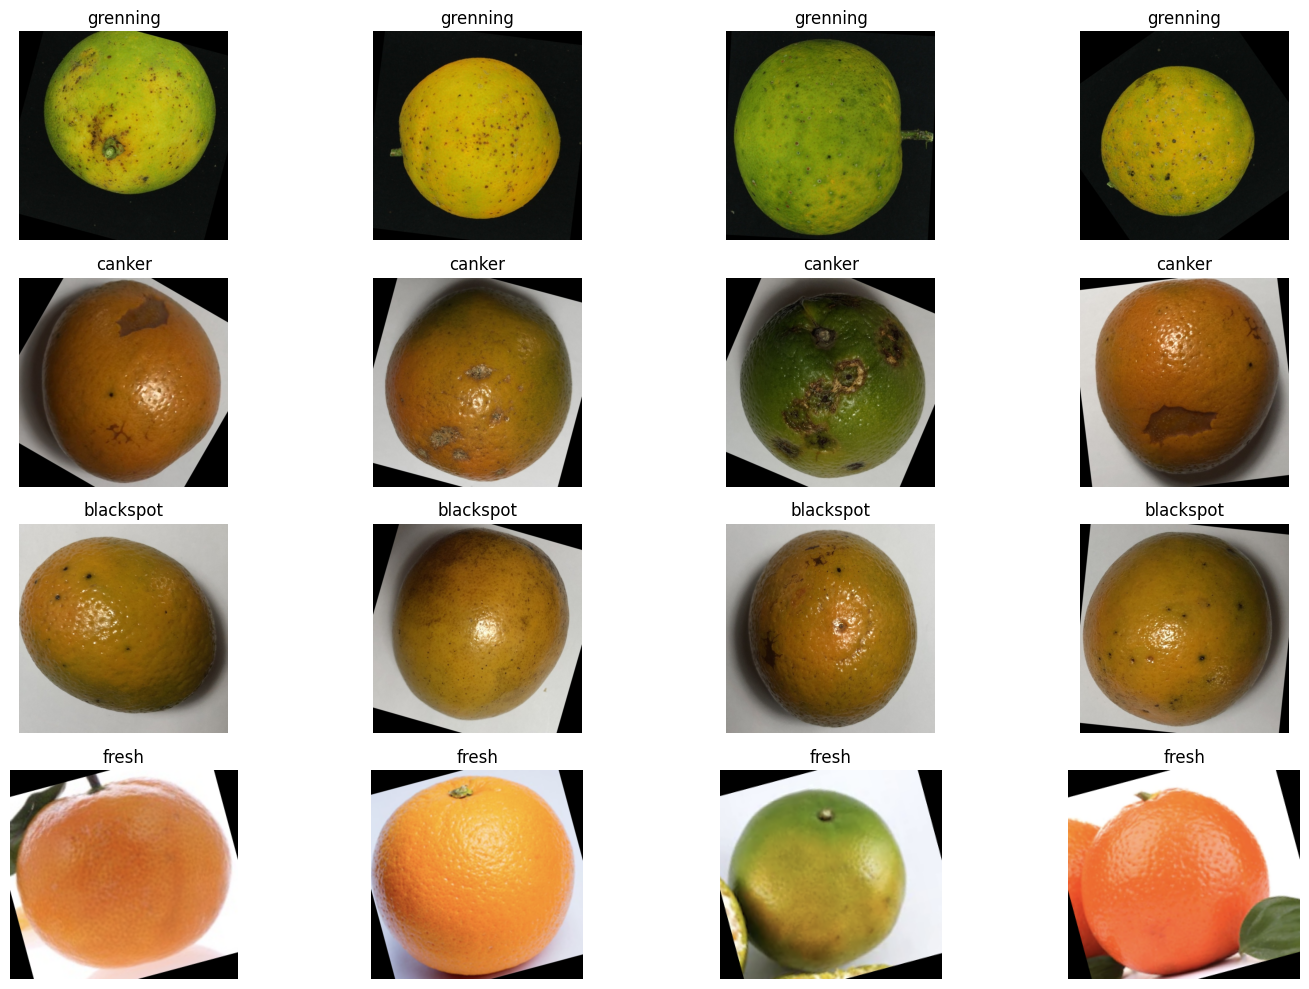

In [18]:
# Function to show sample images
def show_samples(path, num_samples=4):
    plt.figure(figsize=(15, 10))
    for i, cls in enumerate(classes):
        class_path = os.path.join(path, cls)
        images = os.listdir(class_path)[:num_samples]
        
        for j, img_name in enumerate(images):
            img = Image.open(os.path.join(class_path, img_name))
            plt.subplot(len(classes), num_samples, i*num_samples + j + 1)
            plt.imshow(img)
            plt.title(cls)
            plt.axis('off')
    plt.tight_layout()
    plt.show()

# Show train samples
show_samples(test_dir)

Image dimensions summary:
            width      height
count   40.000000   40.000000
mean   690.150000  677.300000
std    200.187291  218.819935
min    160.000000  154.000000
25%    734.000000  701.500000
50%    800.000000  800.000000
75%    800.000000  800.000000
max    800.000000  800.000000


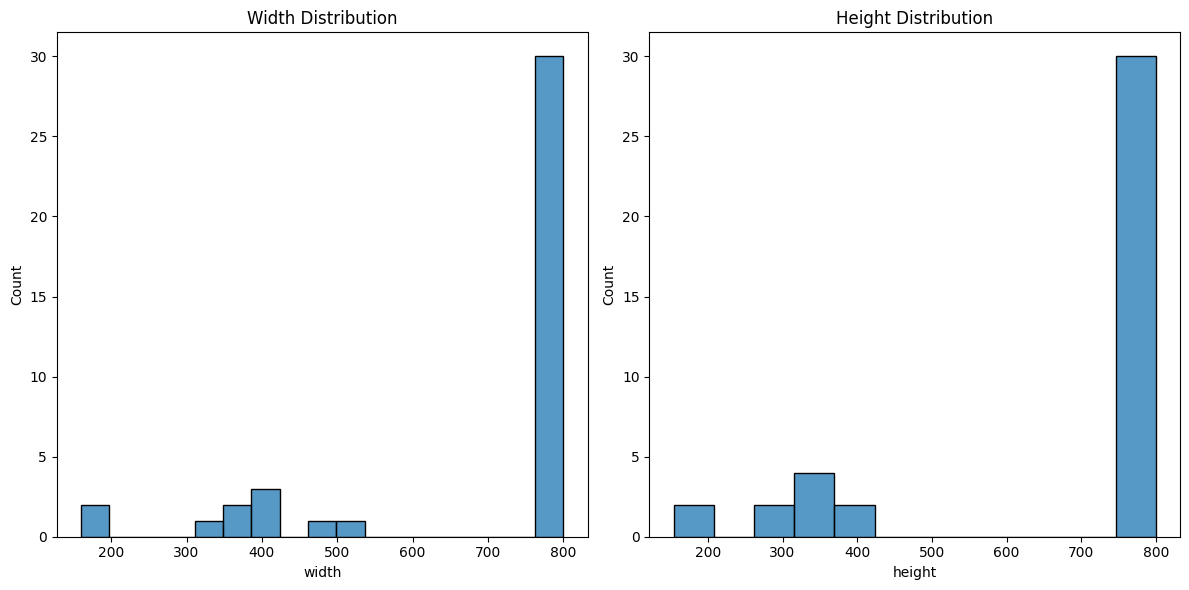

In [21]:
# Suppress all warnings 
warnings.filterwarnings('ignore')
# Check image dimensions
def check_dimensions(path):
    dimensions = []
    for cls in classes:
        class_path = os.path.join(path, cls)
        for img_name in os.listdir(class_path)[:10]:  # Check first 10 images
            img = Image.open(os.path.join(class_path, img_name))
            dimensions.append(img.size)
    
    return pd.DataFrame(dimensions, columns=['width', 'height'])

dim_df = check_dimensions(train_path)
print("Image dimensions summary:")
print(dim_df.describe())

# Plot dimensions distribution
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(dim_df['width'])
plt.title('Width Distribution')
plt.subplot(1, 2, 2)
sns.histplot(dim_df['height'])
plt.title('Height Distribution')
plt.tight_layout()
plt.show()

# **Preprocessing**

In [14]:

augmented_dir = '/kaggle/working/augmented_dataset'
os.makedirs(augmented_dir, exist_ok=True)

# Set image size for EfficientNetB0
IMG_SIZE = (224, 224)

# Data augmentation with EfficientNetB0 preprocessing
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # EfficientNet-specific preprocessing
    shear_range=0.2,          # Random shear
    zoom_range=0.2,           # Random zoom
    horizontal_flip=True,     # Random horizontal flip
    rotation_range=20,        # Add rotation for variety
    width_shift_range=0.2,    # Add width shift
    height_shift_range=0.2,   # Add height shift
    fill_mode='nearest',      # Fill empty pixels
    validation_split=0.2      # 20% for validation
)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Function to create the data generator
def create_generator(directory, datagen, subset=None):
    return datagen.flow_from_directory(
        directory,
        target_size=IMG_SIZE,
        batch_size=32,
        class_mode='categorical',
        subset=subset,
        classes=['grenning', 'canker', 'blackspot', 'fresh']  # Ensure consistent class order
    )

# Step 1: Pre-generate augmented images to reach 500 per class (optional)
def augment_to_target(source_dir, target_dir, target_count=500):
    for cls in ['grenning', 'canker', 'blackspot', 'fresh']:
        src_cls_dir = os.path.join(source_dir, cls)
        aug_cls_dir = os.path.join(target_dir, cls)
        os.makedirs(aug_cls_dir, exist_ok=True)
        
        # Copy original images to augmented directory
        for img_name in os.listdir(src_cls_dir):
            src_path = os.path.join(src_cls_dir, img_name)
            dst_path = os.path.join(aug_cls_dir, img_name)
            save_img(dst_path, img_to_array(load_img(src_path)))
        
        # Calculate how many more images are needed
        current_count = len(os.listdir(src_cls_dir))
        aug_needed = target_count - current_count
        
        print(f"Augmenting {cls}: {current_count} -> {target_count} (+{aug_needed})")
        
        i = 0
        img_list = os.listdir(src_cls_dir)
        while i < aug_needed:
            img_name = img_list[i % len(img_list)]  # Cycle through original images
            img_path = os.path.join(src_cls_dir, img_name)
            img = load_img(img_path, target_size=IMG_SIZE)
            img_array = img_to_array(img)
            img_array = img_array.reshape((1,) + img_array.shape)  # Add batch dimension
            
            # Generate one augmented image
            for batch in train_datagen.flow(img_array, batch_size=1):
                aug_img = batch[0]  # Already preprocessed by preprocess_input
                save_img(os.path.join(aug_cls_dir, f'aug_{i}_{img_name}'), aug_img)
                i += 1
                break  # One image per iteration

# Run augmentation (uncomment to pre-generate images)
augment_to_target(train_path, augmented_dir)

# Step 2: Create generators (use augmented_dir if pre-generated, else train_path)
train_generator = create_generator(augmented_dir if os.path.exists(os.path.join(augmented_dir, 'grenning')) else train_path, 
                                   train_datagen, subset='training')
validation_generator = create_generator(augmented_dir if os.path.exists(os.path.join(augmented_dir, 'grenning')) else train_path, 
                                        train_datagen, subset='validation')
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='categorical',
    classes=['grenning', 'canker', 'blackspot', 'fresh']
)

# Verify generator outputs
print(f"Train samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Test samples: {test_generator.samples}")

Augmenting grenning: 347 -> 500 (+153)
Augmenting canker: 179 -> 500 (+321)
Augmenting blackspot: 184 -> 500 (+316)
Augmenting fresh: 281 -> 500 (+219)
Found 1600 images belonging to 4 classes.
Found 400 images belonging to 4 classes.
Found 99 images belonging to 4 classes.
Train samples: 1600
Validation samples: 400
Test samples: 99


# **Custom cnn model**

In [25]:
# Define the CNN model
model_0 = Sequential()

# Convolutional Block 1
model_0.add(Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 3), padding='same'))
model_0.add(BatchNormalization())
model_0.add(MaxPooling2D((2, 2)))

# Convolutional Block 2
model_0.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model_0.add(BatchNormalization())
model_0.add(MaxPooling2D((2, 2)))

# Convolutional Block 3
model_0.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model_0.add(BatchNormalization())
model_0.add(MaxPooling2D((2, 2)))

# Flatten and Dense Layers
model_0.add(Flatten())
model_0.add(Dense(256, activation='relu'))
model_0.add(Dropout(0.4))
model_0.add(Dense(128, activation='relu'))
model_0.add(Dropout(0.3))
model_0.add(Dense(train_generator.num_classes, activation='softmax'))  # 4 classes

# Optimizer with learning rate decay
opt = Adam(learning_rate=0.001, decay=1e-6)

# Compile the model
model_0.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=7, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)

In [26]:
# Train the model
history = model_0.fit(
    train_generator,
    epochs=25,
    validation_data=validation_generator,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate the model on the test set
test_loss, test_acc = model_0.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")


Epoch 1/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 37s 483ms/step - accuracy: 0.6336 - loss: 19.6940 - val_accuracy: 0.5000 - val_loss: 267.2375 - learning_rate: 0.0010
Epoch 2/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 395ms/step - accuracy: 0.7662 - loss: 9.7699 - val_accuracy: 0.4850 - val_loss: 262.7828 - learning_rate: 0.0010
Epoch 3/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 387ms/step - accuracy: 0.7495 - loss: 9.3248 - val_accuracy: 0.5750 - val_loss: 86.9730 - learning_rate: 0.0010
Epoch 4/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 388ms/step - accuracy: 0.7992 - loss: 3.4885 - val_accuracy: 0.8025 - val_loss: 3.1963 - learning_rate: 0.0010
Epoch 5/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 394ms/step - accuracy: 0.7747 - loss: 3.0207 - val_accuracy: 0.8050 - val_loss: 7.8896 - learning_rate: 0.0010
Epoch 6/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 391ms/step - accuracy: 0.7927 - loss: 2.7455 - val_accuracy: 0.7925 - val_loss: 3.0211 - learning_rate: 0.0010
Epoch 7/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 393ms/step - accuracy: 0.8163 - lo

In [29]:
# Define the CNN model
model_1 = Sequential()

# Convolutional Block 1
model_1.add(Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 3), padding='same'))
model_1.add(BatchNormalization())
model_1.add(MaxPooling2D((2, 2)))

# Convolutional Block 2
model_1.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model_1.add(BatchNormalization())
model_1.add(MaxPooling2D((2, 2)))

# Convolutional Block 3
model_1.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model_1.add(BatchNormalization())
model_1.add(MaxPooling2D((2, 2)))

# Flatten and Dense Layers with L2 regularization
model_1.add(Flatten())
model_1.add(Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model_1.add(Dropout(0.5))  # Increased dropout
model_1.add(Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model_1.add(Dropout(0.5))  # Increased dropout
model_1.add(Dense(train_generator.num_classes, activation='softmax'))
# Optimizer with lower initial learning rate
opt = Adam(learning_rate=0.0001, decay=1e-6)

# Compile the model
model_1.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks with increased patience
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)

In [30]:
# Train the model
history = model_1.fit(
    train_generator,
    epochs=25,
    validation_data=validation_generator,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate the model on the test set
test_loss, test_acc = model_1.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")


Epoch 1/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 28s 414ms/step - accuracy: 0.5687 - loss: 10.4408 - val_accuracy: 0.4375 - val_loss: 23.5148 - learning_rate: 1.0000e-04
Epoch 2/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 396ms/step - accuracy: 0.7328 - loss: 9.0923 - val_accuracy: 0.5750 - val_loss: 10.1459 - learning_rate: 1.0000e-04
Epoch 3/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 392ms/step - accuracy: 0.7435 - loss: 8.3452 - val_accuracy: 0.7425 - val_loss: 8.1861 - learning_rate: 1.0000e-04
Epoch 4/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 392ms/step - accuracy: 0.7580 - loss: 7.6983 - val_accuracy: 0.7825 - val_loss: 7.0711 - learning_rate: 1.0000e-04
Epoch 5/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 391ms/step - accuracy: 0.7411 - loss: 7.2696 - val_accuracy: 0.8150 - val_loss: 6.7746 - learning_rate: 1.0000e-04
Epoch 6/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 394ms/step - accuracy: 0.7333 - loss: 7.0772 - val_accuracy: 0.8225 - val_loss: 6.4069 - learning_rate: 1.0000e-04
Epoch 7/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 390ms/step - 

In [34]:

# Define the CNN model (3 layers)
model_2 = Sequential()

# Convolutional Block 1
model_2.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3), padding='same', kernel_regularizer=l2(0.01)))
model_2.add(BatchNormalization())
model_2.add(MaxPooling2D((2, 2)))

# Convolutional Block 2
model_2.add(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01)))
model_2.add(BatchNormalization())
model_2.add(MaxPooling2D((2, 2)))

# Convolutional Block 3
model_2.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01)))
model_2.add(BatchNormalization())
model_2.add(MaxPooling2D((2, 2)))

# Global Pooling and Dense Layers
model_2.add(GlobalAveragePooling2D())  # Replaces Flatten for efficiency
model_2.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
model_2.add(Dropout(0.5))
model_2.add(Dense(train_generator.num_classes, activation='softmax'))  # 4 classes

# Optimizer with gradient clipping
opt = Adam(learning_rate=0.0001, clipnorm=1.0)

# Compile the model
model_2.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)

In [35]:
# Train the model
history = model_2.fit(
    train_generator,
    epochs=25,
    validation_data=validation_generator,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate the model on the test set
test_loss, test_acc = model_2.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")


Epoch 1/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 32s 439ms/step - accuracy: 0.5226 - loss: 3.6754 - val_accuracy: 0.4900 - val_loss: 4.3378 - learning_rate: 1.0000e-04
Epoch 2/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 390ms/step - accuracy: 0.8026 - loss: 2.9675 - val_accuracy: 0.4975 - val_loss: 3.5483 - learning_rate: 1.0000e-04
Epoch 3/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 383ms/step - accuracy: 0.8387 - loss: 2.7561 - val_accuracy: 0.6025 - val_loss: 3.1580 - learning_rate: 1.0000e-04
Epoch 4/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 385ms/step - accuracy: 0.8680 - loss: 2.5887 - val_accuracy: 0.8425 - val_loss: 2.7452 - learning_rate: 1.0000e-04
Epoch 5/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 383ms/step - accuracy: 0.8854 - loss: 2.4686 - val_accuracy: 0.8850 - val_loss: 2.4918 - learning_rate: 1.0000e-04
Epoch 6/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 387ms/step - accuracy: 0.9043 - loss: 2.3339 - val_accuracy: 0.8800 - val_loss: 2.3249 - learning_rate: 1.0000e-04
Epoch 7/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 385ms/step - acc

# **EfficientNet**

In [23]:
# Load pre-trained EfficientNetB0 model with 224x224 input shape
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze most of the base model layers
for layer in base_model.layers[:-10]:  # Fine-tune only the last 10 layers
    layer.trainable = False

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
# Increased regularization and dropout
x = Dense(256, activation='relu', kernel_regularizer=l2(0.002))(x)
x = Dropout(0.5)(x)  # Increased dropout
x = Dense(128, activation='relu', kernel_regularizer=l2(0.002))(x)
x = Dropout(0.4)(x)  # Increased dropout
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

# Create the model
efficientnet_model = Model(inputs=base_model.input, outputs=predictions)

# Lower initial learning rate
opt = Adam(learning_rate=0.0001, decay=1e-6)
efficientnet_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Improved callbacks
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, min_lr=1e-6)

# Train the model
history = efficientnet_model.fit(
    train_generator,
    epochs=25,
    validation_data=validation_generator,
    callbacks=[early_stopping, reduce_lr]
)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 54s 604ms/step - accuracy: 0.4755 - loss: 2.3909 - val_accuracy: 0.9100 - val_loss: 1.7498 - learning_rate: 1.0000e-04
Epoch 2/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 392ms/step - accuracy: 0.8614 - loss: 1.6764 - val_accuracy: 0.9450 - val_loss: 1.3807 - learning_rate: 1.0000e-04
Epoch 3/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 396ms/step - accuracy: 0.9277 - loss: 1.4139 - val_accuracy: 0.9725 - val_loss: 1.2583 - learning_rate: 1.0000e-04
Epoch 4/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 389ms/step - accuracy: 0.9471 - loss: 1.3156 - val_accuracy: 0.9725 - val_loss: 1.2159 - learning_rate: 1.0000e-04
Epoch 5/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 389ms/step - accuracy: 0.9616 - loss: 1.2458 - val_accuracy: 0.9675 - val_loss: 1.1987 - learning_rate: 1.0000e-04
Epoch 6/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 394ms/step - accuracy: 0.9731 - loss: 1.1959 - val_accuracy: 0.9800 - val_loss: 1.1342 - learning_rate: 1.0000e-04
Epoch 7

In [24]:
# Evaluate the model on the test set
test_loss, test_acc = efficientnet_model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.9536 - loss: 0.6665  
Test Accuracy: 0.9596


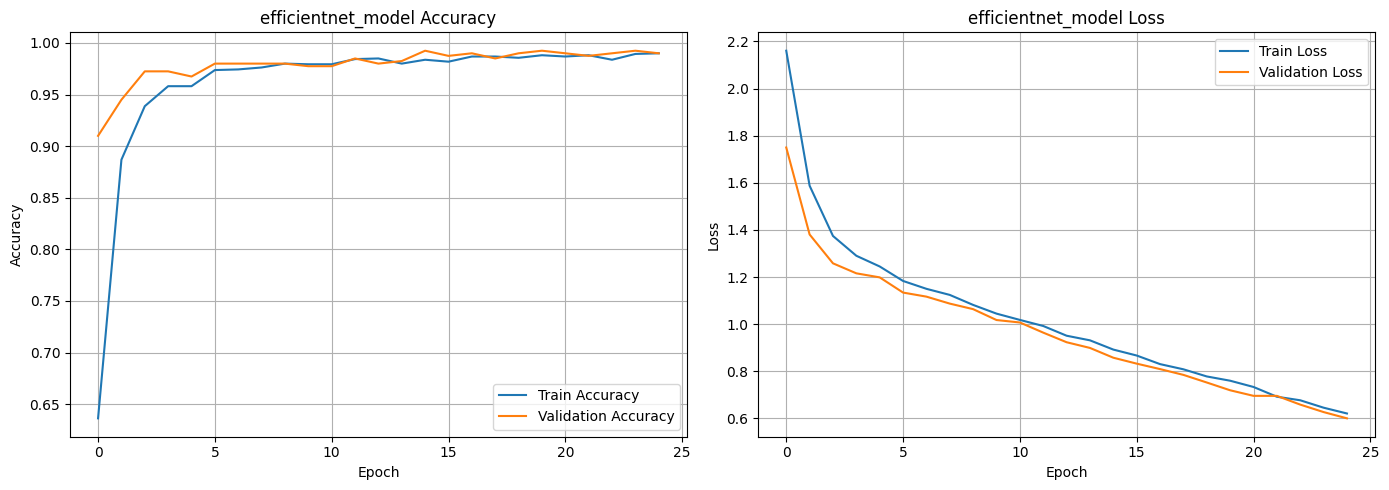

In [26]:
# Call the function
plot_training_history(history, model_name='efficientnet_model')

In [ ]:
efficientnet_model.save('orange_disease_efficientnetB0.h5')

In [31]:
# Create download link
FileLink('orange_disease_efficientnetB0.h5')


/kaggle/working/orange_disease_efficientnetB0.h5

# **Resnet50**

In [20]:
# Load pre-trained ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze most layers
for layer in base_model.layers[:-10]:
    layer.trainable = False

# Add custom head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.002))(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.002))(x)
x = Dropout(0.4)(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

# Create the model
resnet50_model = Model(inputs=base_model.input, outputs=predictions)

# Compile
opt = Adam(learning_rate=0.0001, decay=1e-6)
resnet50_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

# Train
history_resnet = resnet50_model.fit(
    train_generator,
    epochs=25,
    validation_data=validation_generator,
    callbacks=[early_stopping, reduce_lr]
)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


50/50 ━━━━━━━━━━━━━━━━━━━━ 45s 527ms/step - accuracy: 0.4802 - loss: 2.5241 - val_accuracy: 0.9475 - val_loss: 1.3899 - learning_rate: 1.0000e-04
Epoch 2/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 396ms/step - accuracy: 0.8889 - loss: 1.5155 - val_accuracy: 0.9675 - val_loss: 1.3065 - learning_rate: 1.0000e-04
Epoch 3/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 397ms/step - accuracy: 0.9522 - loss: 1.3470 - val_accuracy: 0.9825 - val_loss: 1.2367 - learning_rate: 1.0000e-04
Epoch 4/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 23s 400ms/step - accuracy: 0.9661 - loss: 1.2900 - val_accuracy: 0.9800 - val_loss: 1.2250 - learning_rate: 1.0000e-04
Epoch 5/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 396ms/step - accuracy: 0.9753 - loss: 1.2273 - val_accuracy: 0.9700 - val_loss: 1.1909 - learning_rate: 1.0000e-04
Epoch 6/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 397ms/step - accuracy: 0.9735 - loss: 1.1950 - val_accuracy: 0.9775 - val_loss: 1.1409 - learning_rate: 1.0000e-04
Epoch 7/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 396ms/step - accuracy: 0.97

In [21]:
# Evaluate the model on the test set
test_loss, test_acc = resnet50_model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 902ms/step - accuracy: 0.9599 - loss: 0.8063
Test Accuracy: 0.9596


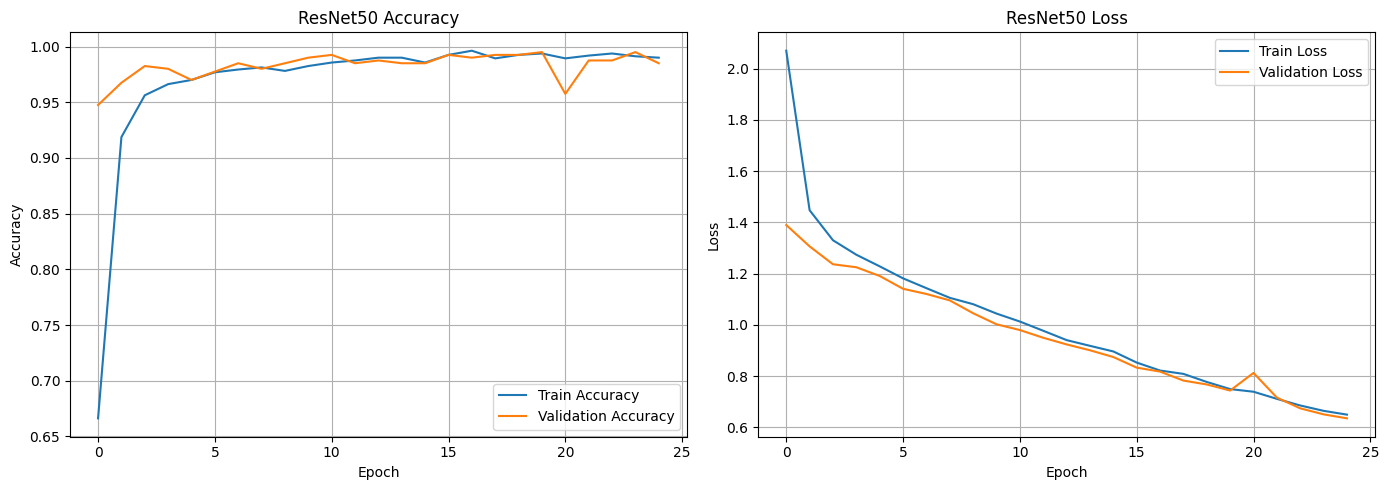

In [22]:

def plot_training_history(history, model_name='Model'):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(14, 5))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Train Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Train Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Call the function
plot_training_history(history_resnet, model_name='ResNet50')
